In [1]:
import os
import sys
import torch
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.optim as optim
import math

import import_ipynb
from CustomDataset import ControlsDataset
from Model import ConvNet
from Trainer import Trainer

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('using device', device)

importing Jupyter notebook from CustomDataset.ipynb
importing Jupyter notebook from Model.ipynb
importing Jupyter notebook from Trainer.ipynb
using device cuda


In [2]:
torch.cuda.empty_cache()

In [3]:
dataset = ControlsDataset(stack_size = 3, 
                          stride = 30, 
                          batch_size = 15,
                          size = 200,
                          img_folder = '../data/cropped_vflip/', 
                          csv_path = '../data/cropped_vflip/data.csv')
print("Data size", len(dataset.labels))

Total training stacks 7
Total validation stacks 7
Data size 22038


In [4]:
outputs = 1
image_shape = dataset[0]['image'].shape

net = ConvNet(outputs, image_shape).to(device)
print("number of parameters: ", sum(p.numel() for p in net.parameters()))

units after conv 22400
conv parameters:  48992
fc parameters:  12546241
number of parameters:  12595233


In [5]:
optimizer = optim.Adam(net.parameters())
criterion = nn.MSELoss()
trainer = Trainer(device, net, dataset, optimizer, criterion)


Training Loss: 0.09818
Validation Loss: 0.67682


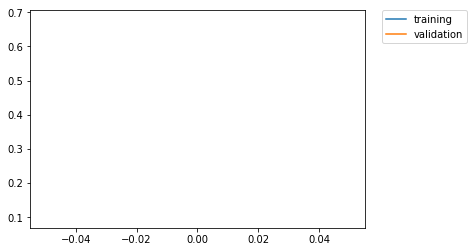


Training Loss: 0.06664
Validation Loss: 2.13808


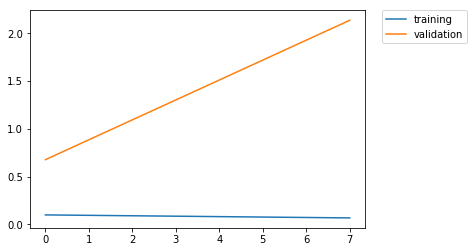


Training Loss: 0.04067
Validation Loss: 1.07742


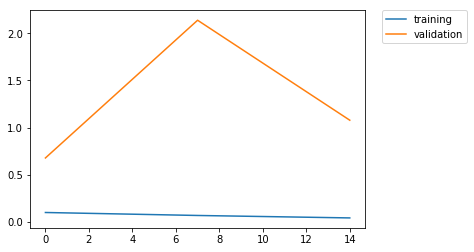


Training Loss: 0.01806
Validation Loss: 0.80467


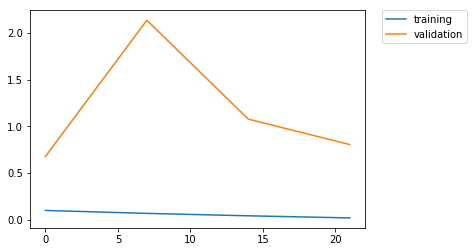


Training Loss: 0.01394
Validation Loss: 0.2882


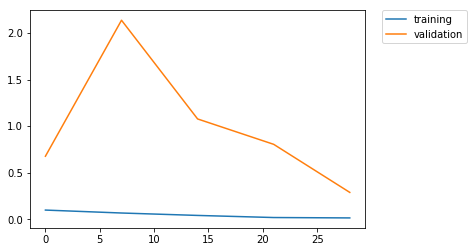


Training Loss: 0.00942
Validation Loss: 0.16962


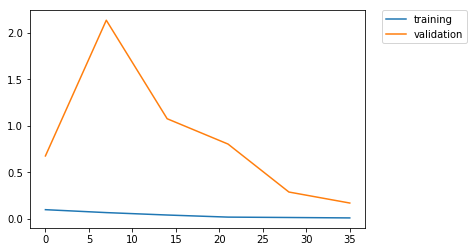


Training Loss: 0.00741
Validation Loss: 0.15524


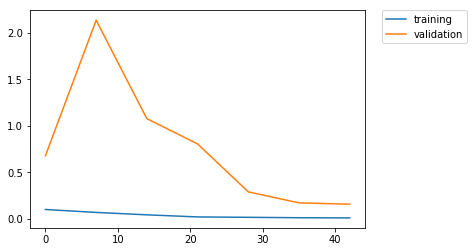


Training Loss: 0.00433
Validation Loss: 0.10698


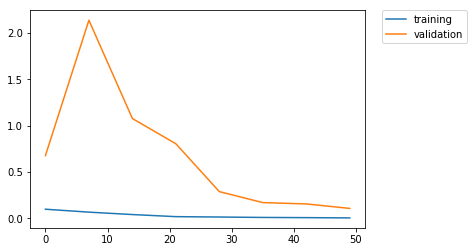


Training Loss: 0.00556
Validation Loss: 0.08798


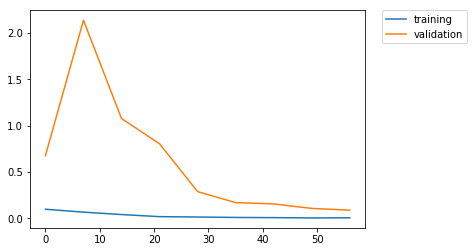


Training Loss: 0.00518
Validation Loss: 0.07813


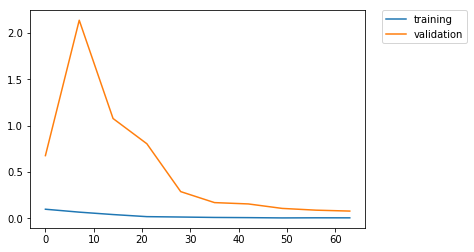


Training Loss: 0.00243
Validation Loss: 0.07864


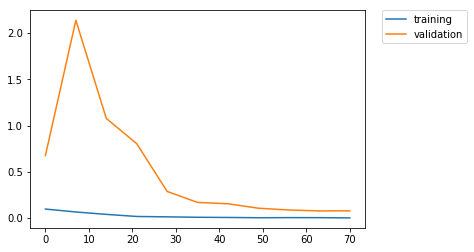


Training Loss: 0.00174
Validation Loss: 0.09392


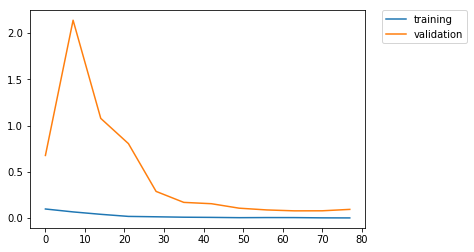


Training Loss: 0.00308
Validation Loss: 0.06751


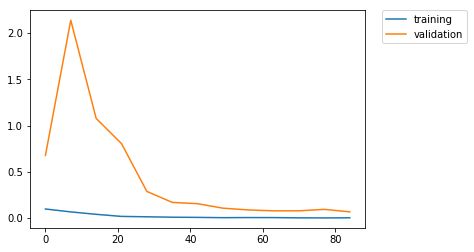


Training Loss: 0.00337
Validation Loss: 0.05895


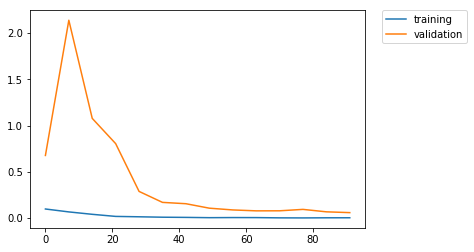


Training Loss: 0.00124
Validation Loss: 0.07405


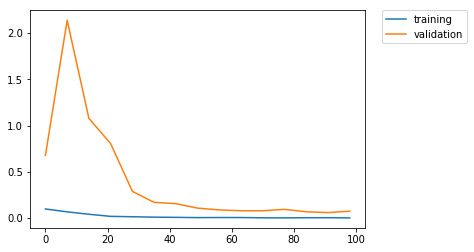


Training Loss: 0.00282
Validation Loss: 0.09133


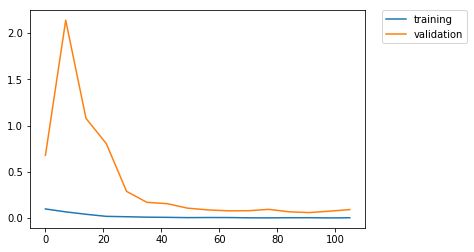


Training Loss: 0.00402
Validation Loss: 0.07743


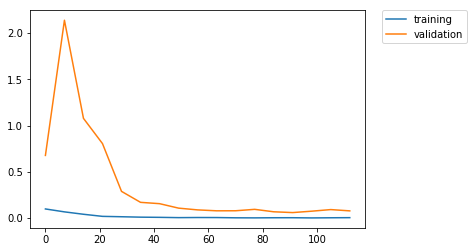


Training Loss: 0.00186
Validation Loss: 0.10039


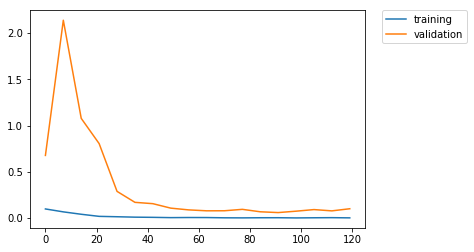


Training Loss: 0.00116
Validation Loss: 0.09581


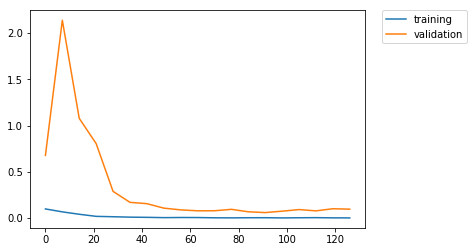


Training Loss: 0.00266
Validation Loss: 0.07999


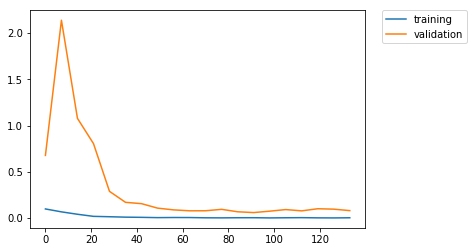


Training Loss: 0.00155
Validation Loss: 0.09702


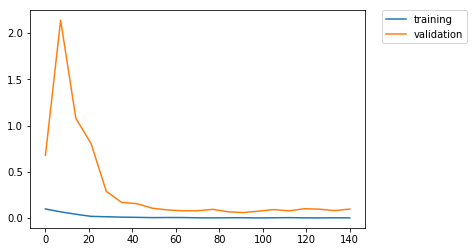


Training Loss: 0.00156
Validation Loss: 0.07373


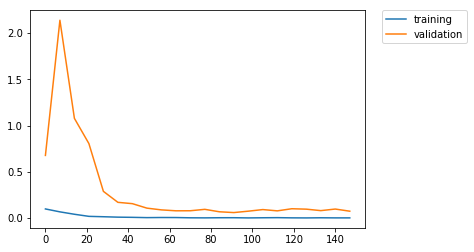


Training Loss: 0.00368
Validation Loss: 0.07725


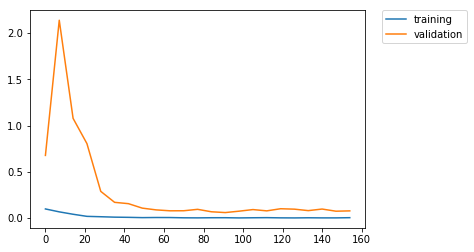


Training Loss: 0.00072
Validation Loss: 0.06744


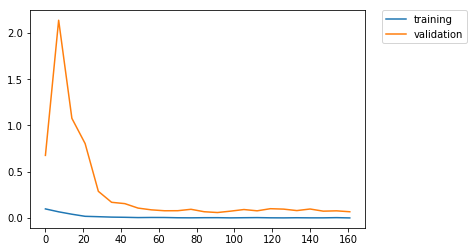


Training Loss: 0.00133
Validation Loss: 0.07278


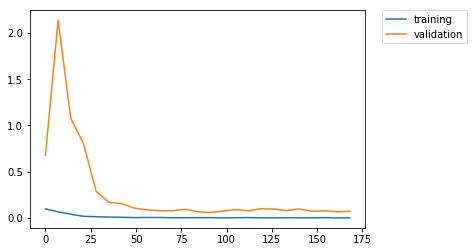


Training Loss: 0.00121
Validation Loss: 0.07045


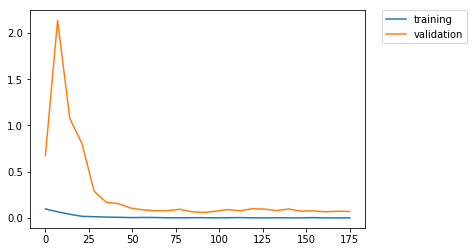


Training Loss: 0.00174
Validation Loss: 0.08402


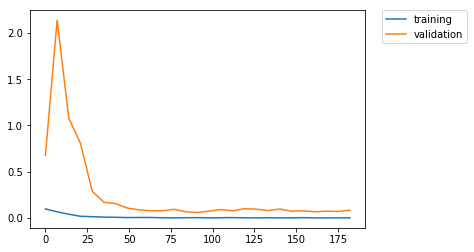


Training Loss: 0.00114
Validation Loss: 0.10011


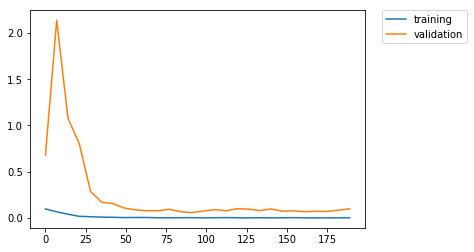


Training Loss: 0.00161
Validation Loss: 0.09951


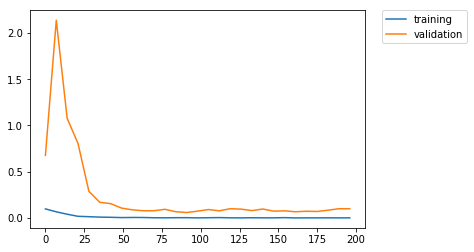


Training Loss: 0.00135
Validation Loss: 0.09497


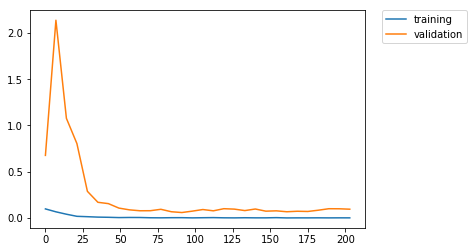

In [6]:
epochs = 30
report_period = 10
trainer.fit(epochs, report_period)

Went through 6 batches
Predicted


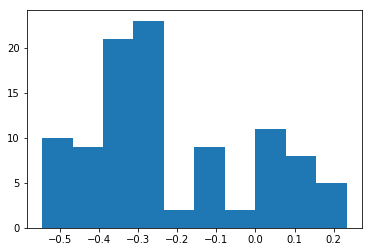

Correct


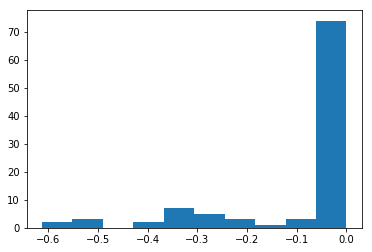

Validation Loss: 0.11127740144729614


In [7]:
def validation_accuracy(dataset):
    total = 0
    correct = 0
    loss = 0
    predictions = []
    answers = []
    for i_batch, sampled_batch in enumerate(dataset.validloader):
        images = sampled_batch['image'].to(device).float()
        controls = sampled_batch['control'].to(device).float()
        controls = torch.flatten(controls)
        prediction = net(images)
        prediction = torch.flatten(prediction)
        predictions += list(prediction.detach().cpu().numpy())
        answers+= list(controls.detach().cpu().numpy())
        
        loss += criterion(prediction,controls)
    print("Went through "+str(i_batch)+" batches")
    print("Predicted")
    plt.hist(predictions)
    plt.show()
    print("Correct")
    plt.hist(answers)
    plt.show()
    return loss/i_batch

loss = validation_accuracy(dataset)
print("Validation Loss: {}".format(loss))

In [8]:
# Visualize feature maps
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

net.conv1.register_forward_hook(get_activation('conv1'))
net.conv2.register_forward_hook(get_activation('conv2'))
net.conv3.register_forward_hook(get_activation('conv3'))

def getActivations(name):
    act = activation[name].squeeze()
    act = act.cpu()
    act = act.detach().numpy()
    print("Convolution: "+name)
    print("Activation size: "+str(act.shape[1:]))

    nrows = 2
    ncols = 4
    
    fig, axarr = plt.subplots(nrows,ncols, figsize=(12, 4))
    for x in range(nrows):
        for y in range(ncols):
            axarr[x][y].imshow(act[ncols*x + y], cmap='gray')
    plt.show()

Convolution: conv1
Activation size: (55, 100)


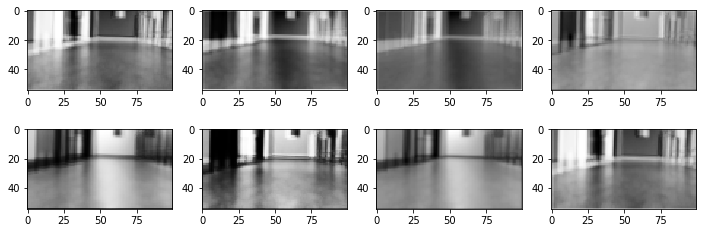

Convolution: conv2
Activation size: (14, 25)


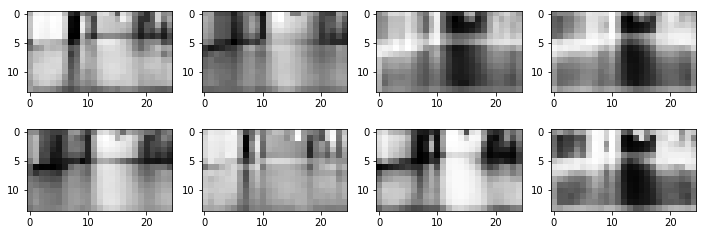

Convolution: conv3
Activation size: (14, 25)


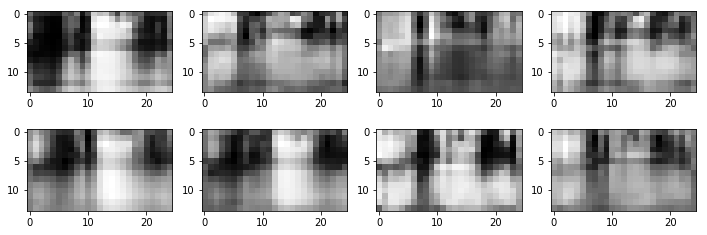

Output: tensor([[0.0030]], device='cuda:0', grad_fn=<AddmmBackward>)
Control: tensor([-0.])


In [9]:
net.eval()
for i, batch in enumerate(dataset.dataloader):
    if i > 0:
        break
    image = batch['image'][0].float()
    control = batch['control'][0].float()
    image = image.reshape(1,9,220,400).to(device)
    output = net(image)
    
getActivations("conv1")
getActivations("conv2")
getActivations("conv3")
print("Output: "+str(output))
print("Control: "+str(control))